# Network Sampling with Karate Club Network

This notebook demonstrates how to use the **fastmaxent** package to generate random networks with specified expected degree and strength sequences. We'll use the classic Zachary's Karate Club network as our example.

## Setup and Imports

Let's install two core packages for inference and sampling. 

In [9]:
from fastmaxent import sampling
from NEMtropy import UndirectedGraph, network_functions

The following packages are not required for sampling but are used for demonstration purposes. 

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

The Zachary's Karate Club network is a classic example in network science. NetworkX provides this network with edge weights representing the strength of relationships.

In [24]:
G = nx.karate_club_graph()

## UBCM Demo: Unweighted Network Sampling

First, let's demonstrate sampling unweighted networks using the **Unweighted Binary Configuration Model (UBCM)**. This preserves the expected degree sequence while ignoring edge weights.

First, let us estimate the parameters of the UBCM given the edgelist of the network. 

In [20]:
# This creates a graph object for NEMtropy
ubcm_graph = UndirectedGraph(edgelist=np.array(G.edges()))

# This estimates the parameters of the UBCM
ubcm_graph.solve_tool(
    model="cm", method="quasinewton", initial_guess="random", tol=1e-08
)
alphas = -np.log(ubcm_graph.x)

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/numba/core/utils.py:621: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/NEMtropy/models_functions.py:198: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/NEMtropy/models_functions.py:199: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]



solution error = 1.4748100696237998e-07


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/numba/core/utils.py:621: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


Let's sample the networks

In [21]:
edge_list = sampling(alpha=alphas, weighted=False, n_samples=10)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The `edge_list` is a list of edge lists, each representing a network. 

In [44]:
edge_list[0][:5]  # print the first 5 edges

[[33, 0], [33, 32], [33, 2], [33, 1], [33, 3]]

We can construct a network from the edge list. For example, to convert it to networkx graph object, we can do the following:

In [23]:
G_rand_list = [nx.from_edgelist(edge_list[i]) for i in range(len(edge_list))]

Let's verify the degree preservation of the sampled networks. 

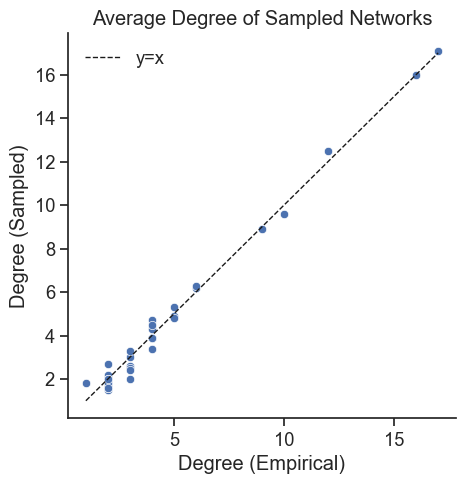

In [52]:
def get_degree_from_edge_list(edges, n_nodes):
    # Degree of a node is the number of times the node appears in the edge list
    # We count the number of occurrences by using np.bincount
    # n_nodes ensures that the length of the count array is the same as the number of nodes
    degree = np.bincount(np.array(edges)[:, :2].reshape(-1), minlength=n_nodes)
    return degree


n_nodes = G.number_of_nodes()

# Compute the empirical degree distribution
deg_emp = get_degree_from_edge_list(G.edges(), n_nodes)

# Compute the average degree of the sampled networks
degree_list = [get_degree_from_edge_list(edges, n_nodes) for edges in edge_list]
average_degree = np.mean(degree_list, axis=0)

# Create visualization comparing original and sampled networks
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(x=deg_emp, y=average_degree, ax=ax)

ax.set_title("Average Degree of Sampled Networks")
ax.set_xlabel("Degree (Empirical)")
ax.set_ylabel("Degree (Sampled)")
ax.plot(
    [deg_emp.min(), deg_emp.max()],
    [deg_emp.min(), deg_emp.max()],
    "k--",
    lw=1,
    label="y=x",
)
ax.legend(frameon=False)

sns.despine()

## UECM Demo: Weighted Network Sampling

Now let's demonstrate the **Undirected Enhanced Configuration Model (UECM)** for weighted networks. This preserves both the expected degree and strength sequences.

The parameters for the UECM are fitted using the `NEMtropy` package as follows:

In [40]:
uecm_graph = UndirectedGraph(edgelist=np.array(list(G.edges(data="weight"))))
uecm_graph.solve_tool(
    model="ecm", method="quasinewton", initial_guess="random", tol=1e-08
)

# Extract alpha and beta parameters
alphas_weighted = -np.log(uecm_graph.x)
betas_weighted = -np.log(uecm_graph.y)

print(f"Fitted alpha parameters: {np.round(alphas_weighted, 3)}")
print(f"Fitted beta parameters: {np.round(betas_weighted, 3)}")


solution error = 5.3888407322233434e-05
Fitted alpha parameters: [-1.084  0.313  0.157  0.893  1.72   1.708  1.61   1.61   1.345  1.059
  1.72   3.204  1.741  1.345  2.131  2.61   2.403  1.059  1.059  0.828
  1.741  1.741  2.131  1.613  1.506  2.451  2.403  1.61   1.227  1.61
  1.374  1.102 -0.235 -1.116]
Fitted beta parameters: [0.263 0.168 0.157 0.202 0.263 0.138 0.167 0.167 0.148 0.874 0.263 0.2
 0.476 0.148 0.301 0.137 0.201 0.874 0.874 0.696 0.476 0.476 0.301 0.076
 0.348 0.05  0.201 0.167 0.477 0.167 0.246 0.137 0.172 0.221]


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/numba/core/utils.py:621: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


In [46]:
# Generate weighted network samples using FastMaxEnt
weighted_edge_list = sampling(
    alpha=alphas_weighted,
    beta=betas_weighted,
    weighted=True,
    n_samples=10,
)

The `weighted_edge_list` is a list of edge lists, each representing a network, with last item being the edge weights. 

In [47]:
weighted_edge_list[0][:5]  # print the first 5 edges

[[33, 0, 3], [33, 32, 2], [33, 2, 2], [33, 1, 2], [33, 31, 2]]

You can construct a network from the edge list, e.g., to convert it to networkx graph object, we can do the following:

In [49]:
G_rand_weighted = nx.Graph()
G_rand_weighted.add_weighted_edges_from(weighted_edge_list[0])

Let's verify the degree and strength preservation of the sampled networks. 

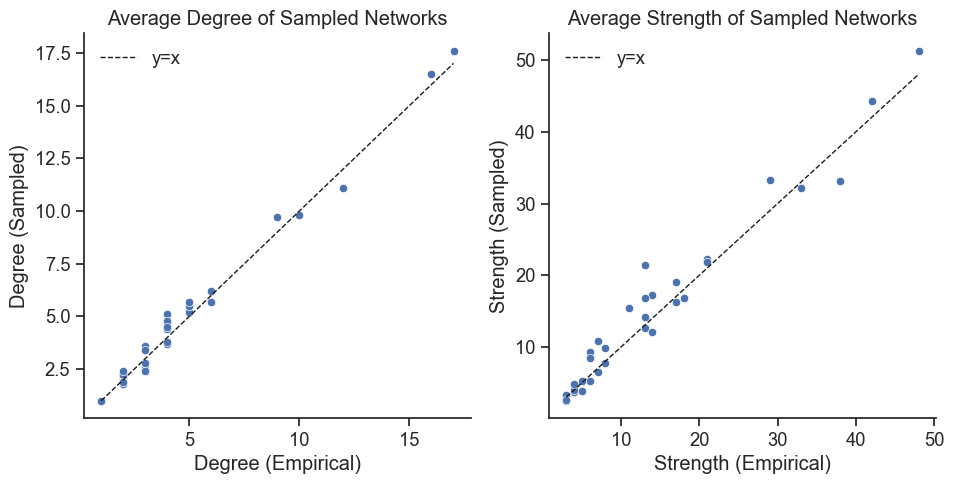

In [58]:
def get_strength_from_edge_list(edges, n_nodes):
    edges = np.array(edges)
    node_indices = edges[:, :2].reshape(-1)
    weights = np.repeat(edges[:, 2], 2)
    strength = np.bincount(node_indices, minlength=n_nodes, weights=weights)
    return strength


# Compute the empirical degree distribution
deg_emp = get_degree_from_edge_list(list(G.edges()), n_nodes)
str_emp = get_strength_from_edge_list(list(G.edges(data="weight")), n_nodes)

# Compute the average degree of the sampled networks
degree_list = [
    get_degree_from_edge_list(edges, n_nodes) for edges in weighted_edge_list
]
average_degree = np.mean(degree_list, axis=0)

# Compute the average strength of the sampled networks
strength_list = [
    get_strength_from_edge_list(edges, n_nodes) for edges in weighted_edge_list
]
average_strength = np.mean(strength_list, axis=0)


# Create comprehensive visualization for weighted networks
fig, axes = plt.subplots(figsize=(11, 5), ncols=2)

ax = axes[0]

sns.scatterplot(x=deg_emp, y=average_degree, ax=ax)

ax.set_title("Average Degree of Sampled Networks")
ax.set_xlabel("Degree (Empirical)")
ax.set_ylabel("Degree (Sampled)")
ax.plot(
    [deg_emp.min(), deg_emp.max()],
    [deg_emp.min(), deg_emp.max()],
    "k--",
    lw=1,
    label="y=x",
)
ax.legend(frameon=False)

ax = axes[1]
sns.scatterplot(x=str_emp, y=average_strength, ax=ax)

ax.set_title("Average Strength of Sampled Networks")
ax.set_xlabel("Strength (Empirical)")
ax.set_ylabel("Strength (Sampled)")
ax.plot(
    [str_emp.min(), str_emp.max()],
    [str_emp.min(), str_emp.max()],
    "k--",
    lw=1,
    label="y=x",
)
ax.legend(frameon=False)
sns.despine()